## CS441: Applied ML - HW 3

### Part 1: Estimating PDFs

Whole image


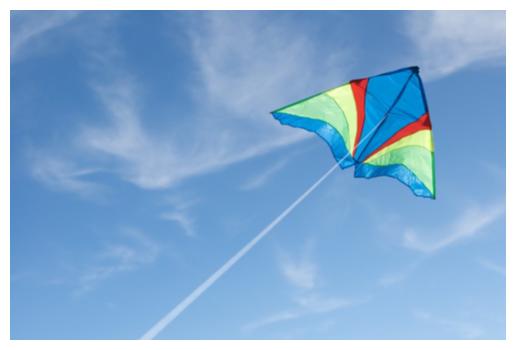

Foreground


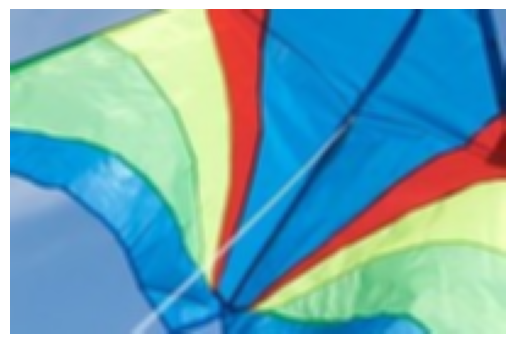

In [34]:
# initalization code

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
# from google.colab import drive
# from google.colab.patches import cv2_imshow
import cv2

# read images
# drive.mount('/content/drive')
# datadir = "/content/drive/My Drive/CS441/24SP/hw3/"
datadir = "./"
im = cv2.imread(datadir + 'kite.jpg')  # this is the full image
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255
im = cv2.blur(im, (3, 3)).clip(0,1)


crop = cv2.imread(datadir + 'kite_crop.jpg')  # this is the cropped image
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255
crop = cv2.blur(crop, (3, 3)).clip(0,1)

# displays a single image
def display_image(im):
  plt.imshow(im)
  plt.axis('off')
  plt.show()

# displays the image, score map, thresholded score map, and masked image
def display_score(im, score_map, thresh):
  display_image(im)
  display_image(np.reshape(score_map, (im.shape[:2])))
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  display_image(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)

print('Whole image')
display_image(im)

print('Foreground')
display_image(crop)


#### Method 1 (per channel hist)

In [32]:
# estimate discrete pdf
def estimate_discrete_pdf(values, nvalues, prior=1):
  '''
    Estimate P(values=v) for each possible v in (0, nvalues)
    Input:
       values: the values of the data
       nvalues: range of values, such that 0 <= values < nvalues
       prior: initial count used to prevent any value from having zero probability
    Output:
       p[nvalues,]: P(values=v) for each v
  '''
  hist, edges = np.histogram(values,bins=nvalues)
  hist = np.clip(hist, prior,None)
  return hist / len(values)

(425068, 3) (26999, 3)


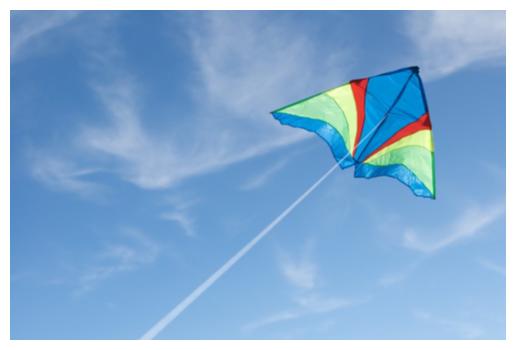

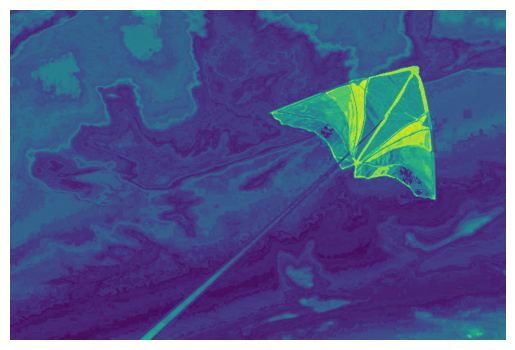

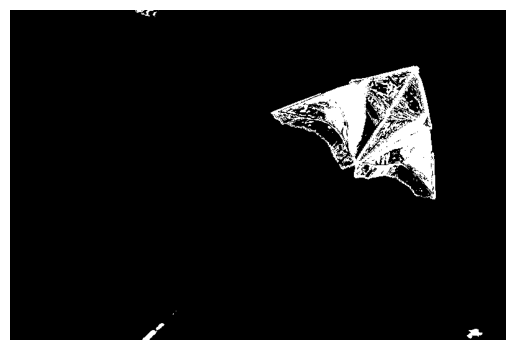

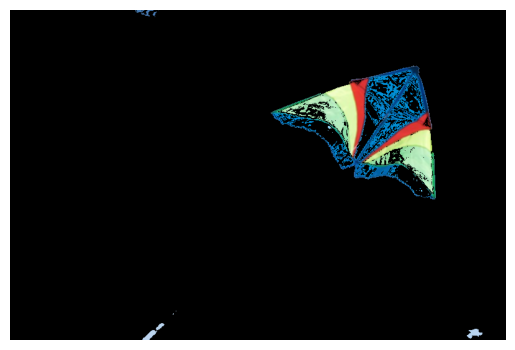

In [33]:
# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))

print(im_3.shape,crop_3.shape)
# estimate PDFs and compute score per pixel
bins = 256

idcs = (im_3 * bins).astype(int).clip(0,bins-1)

pdf_im = estimate_discrete_pdf(im_3[:,0],bins)[idcs[:,0]]
pdf_im *= estimate_discrete_pdf(im_3[:,1],bins)[idcs[:,1]]
pdf_im *= estimate_discrete_pdf(im_3[:,2],bins)[idcs[:,2]]


pdf_crop = estimate_discrete_pdf(crop_3[:,0],bins)[idcs[:,0]]
pdf_crop *= estimate_discrete_pdf(crop_3[:,1],bins)[idcs[:,1]]
pdf_crop *= estimate_discrete_pdf(crop_3[:,2],bins)[idcs[:,2]]


score = np.log(pdf_crop/pdf_im)
t = 2
display_score(im, score_map=score, thresh=t)

#### Method 2 (Kmeans)

In [35]:
# init
# !apt install libomp-dev > /dev/null 2>&1
# !pip install faiss-cpu > /dev/null 2>&1
import faiss

In [36]:
def kmeans_fast(X, K, niter=10):
    X = X.astype(np.float32)
    d = X.shape[1]
    cluster_centers = X[:K].copy()
    index = faiss.IndexFlatL2(d)

    rmse_list = []

    for i in range(niter):
        index.reset()
        index.add(cluster_centers)
        D, I = index.search(X, 1)  # D is the squared distances

        for k in range(K):
            points_in_cluster = X[I.squeeze() == k]
            if len(points_in_cluster) > 0:
                cluster_centers[k] = np.mean(points_in_cluster, axis=0)

    return cluster_centers, rmse_list

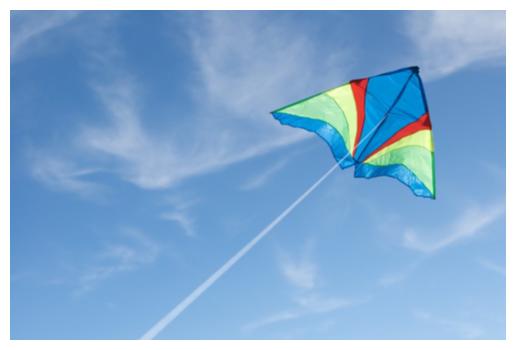

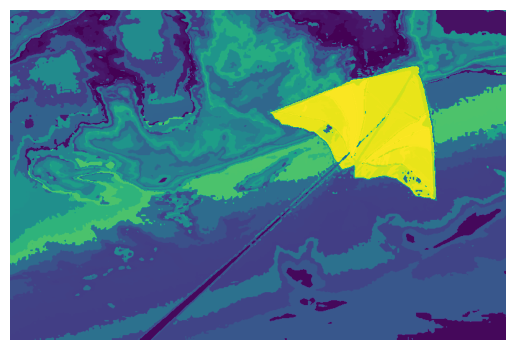

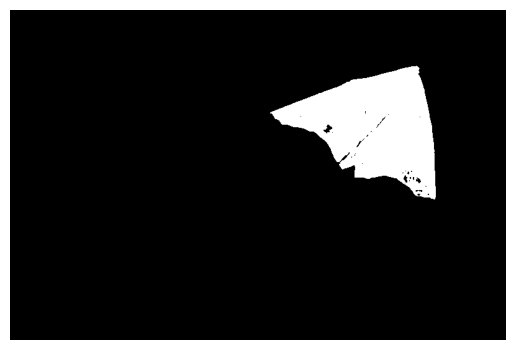

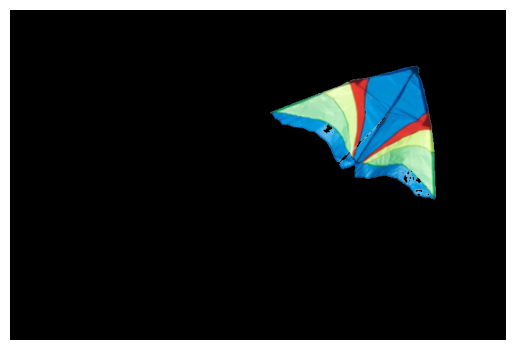

In [37]:
# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))



# estimate PDFs and compute score per pixel

K = 64

# Apparently this shit is wrong
# def get_pdf(img):
#   centers, _ = kmeans_fast(img,K,niter=100)
#   index = faiss.IndexFlatL2(img.shape[1])
#   index.add(centers)
#   D, I = index.search(im_3, 1)
#   I = I.squeeze()
#   freqs = (np.bincount(I)) / len(I)
#   return freqs[I]
# pdf_crop = get_pdf(crop_3)
# pdf_im = get_pdf(im_3)

centers, _ = kmeans_fast(im_3,K,niter=100)
index = faiss.IndexFlatL2(im_3.shape[1])
index.add(centers)
D, I_im = index.search(im_3, 1)
I_im = I_im.squeeze()
freqs = (1+np.bincount(I_im)) / len(I_im)

pdf_im = freqs[I_im]

D, I = index.search(crop_3, 1)
I = I.squeeze()
freqs = (1+np.bincount(I)) / len(I)

pdf_crop = freqs[I_im]




score = np.log(pdf_crop/pdf_im)
t= 1
display_score(im=im, score_map=score, thresh=t)

#### Method 3 (GMM)

In [43]:
from sklearn.mixture import GaussianMixture

# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))


# estimate PDFs and compute score per pixel (can use gmm.score_samples where gmm is the mixture model)
K = 10
covariance_type='full'
gm = GaussianMixture(n_components=K, random_state=0,covariance_type=covariance_type).fit(im_3)

In [86]:
gm2 = GaussianMixture(n_components=K, random_state = 0,covariance_type=covariance_type).fit(crop_3)

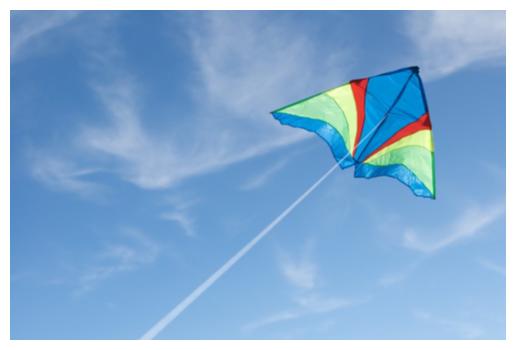

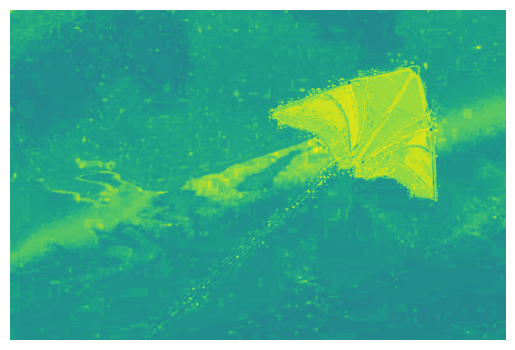

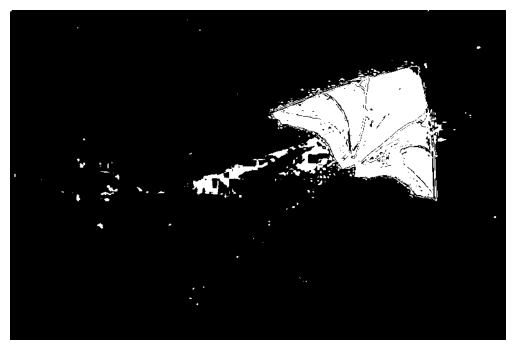

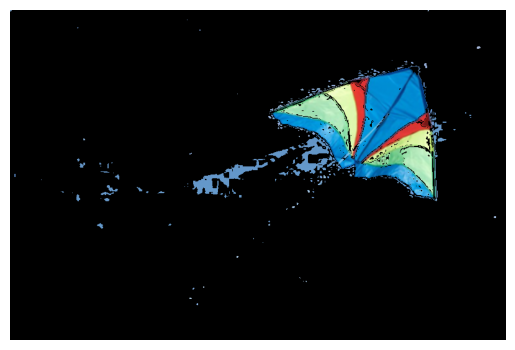

In [92]:
log_pdf_crop = gm2.score_samples(im_3)
log_pdf_im = gm.score_samples(im_3)
score = log_pdf_crop - log_pdf_im
t= 1.25
display_score(im=im, score_map=score, thresh=t)

## Part 2: Robust Estimation

In [2]:
import numpy as np
from matplotlib import pyplot as plt
# from google.colab import drive

# drive.mount('/content/drive')
# datadir = "/content/drive/My Drive/CS441/24SP/hw3/"

datadir = "./"

# load data
T = np.load(datadir + 'salary.npz')
(salary, years, school) = (T['salary'], T['years'], T['school'])

#### 1. No noise
Compute the statistics for the data as a whole

In [3]:
# TO DO
salary_mu = salary.mean()
salary_std = np.std(salary)
salary_min = salary.min()
salary_max = salary.max()
print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

Mean: 123749.835  Std: 61953.77348723623  Min: 64694.0   Max: 611494.0


#### 2. Percentiles
Assume valid data will fall between the 5th and 95th percentile.

In [4]:
pct = 0.05

percentile_5 = np.percentile(salary, 5)
percentile_95 = np.percentile(salary, 95)

filtered_data = salary[(salary >= percentile_5) & (salary <= percentile_95)]

salary_mu = filtered_data.mean()
salary_std = np.std(filtered_data)
salary_min = np.percentile(salary, 5) - (np.percentile(salary, 95)-np.percentile(salary, 5))*(0.05/0.9)
salary_max = np.percentile(salary, 95) + (np.percentile(salary, 95)-np.percentile(salary, 5))*(0.05/0.9)
# TO DO

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

Mean: 113878.65  Std: 15876.450453939286  Min: 75493.8   Max: 159900.79999999973


#### 3. EM
Assume valid data follows a Gaussian distribution, while the fake data has a uniform distribution between the minimum and maximum value of salary.

In [13]:
niter = 20

# initialize by assuming that all scores are good
N = 1
M = len(salary)
print(M)
scores = salary.reshape((N,M))
score_mean = scores.mean(axis=1).reshape((len(scores), 1))  # mu_i
score_std = np.sqrt(np.sum((scores-score_mean)**2, axis=None)/N/M)  # sigma

pz = 0.5 # P(z=1) = 0.5 initially

# print initial estimate
# plot_est(true_score, score_mean)

200


In [20]:
for t in range(niter):
  last_mean = score_mean.copy()

  # E-step
  # update probability that each annotator is good
  p_good = np.zeros((scores.shape[1],1))  # w_a = P(z_a=1 | scores, theta_t)
  for a in range(M):
    p_s_good = pz  # P(s_ia | z=1, mu_i, std)P(z_a=1)
    p_s_bad = 1-pz # P(s_ia | z=0)P(z_a=0)
    for i in range(N):
      p_s_good *= 1/np.sqrt(2*np.pi)/score_std * np.exp(-1/2 * (scores[i,a]-score_mean[i])**2/score_std**2)
      p_s_bad *= 1/(salary.max()-salary.min()) # uniform in range [0, 10]
    p_good[a] = p_s_good / (p_s_good + p_s_bad)

  print('\niter {}'.format(t))
  print(np.round(p_good.transpose()*1000)/1000)

  # M-step
  # assign parameters that maximize likelihood under latent variable likelihoods
  for i in range(N):
    # estimate mean for each image
    w_score_sum_i = 0
    for a in range(M):
      w_score_sum_i += scores[i,a]*p_good[a]
    score_mean[i] = w_score_sum_i / np.sum(p_good)

  # estimate std
  w_sqdiff_sum = 0
  for i in range(N):
    for a in range(M):
      w_sqdiff_sum += p_good[a]*(scores[i,a] - score_mean[i])**2
  score_std = np.sqrt(w_sqdiff_sum / np.sum(p_good) / N)

  # estimate pz
  pz = np.mean(p_good)
  # plot_est(true_score, score_mean)
  print('Std: {:0.3f}'.format(score_std[0]))

  if np.all(np.abs(last_mean-score_mean)<0.00001): # check for convergence
    break


iter 0
[[0.993 0.995 0.995 0.994 0.993 0.995 0.995 0.992 0.994 0.995 0.994 0.986
  0.975 0.995 0.986 0.99  0.995 0.993 0.    0.969 0.988 0.96  0.994 0.995
  0.986 0.995 0.994 0.991 0.    0.967 0.993 0.994 0.995 0.994 0.994 0.995
  0.994 0.98  0.995 0.993 0.995 0.993 0.995 0.962 0.989 0.949 0.994 0.994
  0.994 0.    0.995 0.995 0.995 0.994 0.995 0.995 0.995 0.995 0.995 0.993
  0.995 0.995 0.918 0.86  0.992 0.983 0.995 0.994 0.955 0.995 0.975 0.99
  0.994 0.995 0.995 0.994 0.995 0.981 0.991 0.995 0.994 0.995 0.994 0.995
  0.994 0.995 0.993 0.993 0.995 0.985 0.987 0.993 0.995 0.918 0.995 0.995
  0.995 0.994 0.989 0.99  0.994 0.993 0.993 0.983 0.991 0.982 0.981 0.995
  0.993 0.989 0.985 0.995 0.994 0.99  0.995 0.995 0.995 0.995 0.994 0.969
  0.99  0.993 0.994 0.995 0.994 0.99  0.991 0.    0.    0.981 0.994 0.994
  0.    0.994 0.993 0.994 0.995 0.995 0.995 0.994 0.995 0.995 0.944 0.993
  0.99  0.994 0.985 0.561 0.984 0.987 0.995 0.995 0.995 0.945 0.993 0.994
  0.994 0.    0.977 0.995 0.995

In [36]:
goodsals = salary[(p_good >= 0.5).squeeze()]
salary_min = goodsals.min()
salary_max = goodsals.max()


salary_mu = score_mean.item()
salary_std=score_std[0]

In [37]:

# TO DO


print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

# print the first five indices of salaries that are not likely to be valid
p_valid_given_s = p_good.copy()
print(np.where(p_valid_given_s<0.5)[0][:5])

Mean: 111984.38462960183  Std: 17966.36279750227  Min: 64694.0   Max: 169008.0
[ 18  28  49 127 128]


## Part 4: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

# A

# B

In [72]:
from sklearn.linear_model import LinearRegression
good_entries = (p_good >= 0.5).squeeze()

X = np.vstack((years,school)).T[good_entries]
Y = salary[good_entries]

model = LinearRegression().fit(X,Y)
print(model.coef_[0])



1107.1731484452903


 # C

In [38]:
from sklearn.datasets import load_diabetes
X = load_diabetes(as_frame=True,scaled=False)['data']
Y = load_diabetes(as_frame=True,scaled=False)['target']

In [39]:
age = X['age'].values.astype(int)
sex = X['sex'].values.astype(int)

In [40]:
x_size = age.max()+1
y_size = sex.max()+1
probs = np.zeros((x_size,y_size))
for x,y in zip(age,sex):
  probs[x,y]+=1
probs = probs / probs.sum()
py = probs.sum(axis=0)
px = probs.sum(axis=1)

In [41]:
ans =  0
for x in range(x_size):
  for y in range(y_size):
    if probs[x,y]==0:
      continue
    ans += probs[x,y] * np.log(probs[x,y] / px[x] / py[y])
ans
    

0.09259264627746933

# D

In [88]:
import pandas as pd
df = pd.DataFrame({"age":age,'sex':sex})
ages1 = df[df['sex']==1]['age'].values.reshape(-1,1)
ages2 = df[df['sex']==2]['age'].values.reshape(-1,1)
gm1 = GaussianMixture(n_components=3, random_state=0,covariance_type=covariance_type).fit(ages1)
gm2 = GaussianMixture(n_components=3, random_state=0,covariance_type=covariance_type).fit(ages2)

ps1 = (sex==1).mean()
ps2 = (sex==2).mean()
ages1.size / (ages1.size+ages2.size), ps1

(0.5316742081447964, 0.5316742081447964)

In [91]:
da = 0.01

ans = 0


for a in np.arange(0,100,da):
  pas1 = np.exp(gm1.score_samples(a.reshape(1,1)))
  pas2 = np.exp(gm2.score_samples(a.reshape(1,1)))

  pa1 = pas1 * ps1
  pa2 = pas2 * ps2

  pa = pa1 + pa2

  ans += pa1 * np.log(pa1/pa/ps1) * da
  ans += pa2 * np.log(pa2/pa/ps2) * da
  

ans

array([0.0242696])

In [78]:


# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

ModuleNotFoundError: No module named 'google.colab'